In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

from tqdm import tqdm
from nba_api.stats.static import players, teams
from nba_api.stats.library.parameters import SeasonAll
from nba_api.stats.endpoints import leaguegamelog

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error


pd.options.display.max_columns=200

In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-

In [185]:
seasons = ["20{}-{}".format(x, x+1) for x in range(13, 21)]
print(seasons)
def gather_data(seasons = seasons):
    full_player_data = []
    for season in seasons:
        player_gls = pd.read_csv('./data/player_gamelogs_{}.csv'.format(season), dtype={'GAME_ID':'object'})
        player_gls_adv = pd.read_csv('./data/player_advanced_boxscores_{}.csv'.format(season), dtype={'GAME_ID':'object'})
        player_gls_scoring = pd.read_csv('./data/player_scoring_boxscores_{}.csv'.format(season), dtype={'GAME_ID':'object'})
        player_gls_tracking = pd.read_csv('./data/player_tracking_boxscores_{}.csv'.format(season), dtype={'GAME_ID':'object'})
        
        player_gls = player_gls[['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
       'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS']]

        player_full = pd.merge(player_gls, player_gls_adv, how='left', on=['GAME_ID', 'PLAYER_ID'], suffixes=['', '_x'])
        player_full = pd.merge(player_full, player_gls_scoring, how='left', on=['GAME_ID', 'PLAYER_ID'], suffixes=['', '_x'])
        player_full = pd.merge(player_full, player_gls_tracking, how='left', on=['GAME_ID', 'PLAYER_ID'], suffixes=['', '_x'])
    
        # drop unnecessary columns
        player_full = player_full.drop(columns = ['TEAM_ID', 'TEAM_NAME', 'TEAM_ID_x',
                         'TEAM_ABBREVIATION_x','TEAM_CITY','PLAYER_NAME_x','START_POSITION',
                          'COMMENT','MIN_x','TEAM_ID_x', 'TEAM_ABBREVIATION_x','TEAM_CITY_x', 
                          'PLAYER_NAME_x', 'START_POSITION_x', 'COMMENT_x', 'MIN_x', 
                         'TEAM_ID_x', 'TEAM_ABBREVIATION_x', 'TEAM_CITY_x', 'PLAYER_NAME_x', 
                          'START_POSITION_x', 'COMMENT_x', 'MIN_x', 'AST_x', 'FG_PCT_x',
                         'FG_PCT', 'FG3_PCT', 'FT_PCT', 'E_NET_RATING', 'NET_RATING', 
                         'AST_PCT', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'EFG_PCT', 'TS_PCT', 
                         'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_FT', 'CFG_PCT',
                        'UFG_PCT', 'DFG_PCT'], 
                       errors= 'ignore')

        # Convert date to datetime
        player_full['GAME_DATE'] = pd.to_datetime(player_full['GAME_DATE'])
        
        # Convert W/L to a binary 1/0 for win/loss
        player_full['WL'] = (player_full['WL'].str[0] == 'W').astype(int)
        
        # Add a binary home_game feature
        player_full['HOME_GAME'] = 0 
        player_full['HOME_GAME'] = (player_full['MATCHUP'].str[:6] == player_full['TEAM_ABBREVIATION'].str[:] + ' vs').astype(int)
        
        # convert the percentages into raw numbers (because we will be averaging them, we don't want to average percentages)
        # for example, percentage of points from midrange will be points scored from midrange
        player_full['FG2M'] = player_full['FGM'] - player_full['FG3M']
        player_full['FG2A'] = player_full['FGA'] - player_full['FG3A']
        player_full['PTS_2PT'] = (player_full['PTS'] * player_full['PCT_PTS_2PT']).astype('int8')
        player_full['PTS_2PT_MR'] = (player_full['PTS'] * player_full['PCT_PTS_2PT_MR']).astype('int8')
        player_full['PTS_3PT'] = (player_full['PTS'] * player_full['PCT_PTS_3PT']).astype('int8')
        player_full['PTS_FB'] = (player_full['PTS'] * player_full['PCT_PTS_FB']).astype('int8')
        player_full['PTS_OFF_TOV'] = (player_full['PTS'] * player_full['PCT_PTS_OFF_TOV']).astype('int8')
        player_full['PTS_PAINT'] = (player_full['PTS'] * player_full['PCT_PTS_PAINT']).astype('int8')
        player_full['AST_2PM'] = (player_full['FG2M'] * player_full['PCT_AST_2PM']).astype('int8')
        player_full['UAST_2PM'] = (player_full['FG2M'] * player_full['PCT_UAST_2PM']).astype('int8')
        player_full['AST_3PM'] = (player_full['FG3M'] * player_full['PCT_AST_3PM']).astype('int8')
        player_full['UAST_3PM'] = (player_full['FG3M'] * player_full['PCT_UAST_3PM']).astype('int8')



        player_full = player_full.drop(columns = ['PCT_PTS_2PT', 'PCT_PTS_2PT_MR', 'PCT_PTS_3PT', 
                                                  'PCT_PTS_FB', 'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT',
                                                  'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM',
                                                  'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM', 
                                                  'FGM', 'FGA', 'AST_TOV', 'USG_PCT', 'PACE',
                                                  'PACE_PER40', ], errors='ignore')
        
        
        full_player_data.append(player_full)
        
        
    
    player_df = pd.concat(full_player_data)
    
    
    player_df['home_team_abbr'] = player_df.apply(lambda row: row['TEAM_ABBREVIATION'] if row['HOME_GAME'] == 1 else row['MATCHUP'][-3:], axis=1)
    player_df['away_team_abbr'] = player_df.apply(lambda row: row['TEAM_ABBREVIATION'] if row['HOME_GAME'] == 0 else row['MATCHUP'][-3:], axis=1)
    
    player_df[['home_team_abbr', 'away_team_abbr']] = player_df[['home_team_abbr', 'away_team_abbr']].replace({'NOH':'NOP',
                                                                                                               'NJN':'BKN'})
    
    # Reorder columns
    player_df = player_df[['SEASON_YEAR', 'TEAM_ABBREVIATION', 'PLAYER_NAME', 'PLAYER_ID', 
                           'home_team_abbr', 'away_team_abbr', 'GAME_ID', 
                           'GAME_DATE', 'MATCHUP', 'WL', 'HOME_GAME', 'MIN',
                           'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB',
                           'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD',
                           'PTS', 'PLUS_MINUS', 'E_OFF_RATING', 'E_DEF_RATING',
                           'AST_RATIO', 'TM_TOV_PCT', 'E_USG_PCT',
                           'E_PACE', 'POSS', 'PIE', 'SPD', 'DIST', 'ORBC', 
                           'DRBC', 'RBC', 'TCHS', 'SAST', 'FTAST', 'PASS', 
                           'CFGM', 'CFGA', 'UFGM', 'UFGA', 'DFGM', 'DFGA', 
                           'FG2M', 'FG2A', 'PTS_2PT_MR', 'PTS_FB', 
                           'PTS_OFF_TOV', 'PTS_PAINT', 'AST_2PM',
                           'UAST_2PM', 'AST_3PM', 'UAST_3PM']]
    
    return player_df

player_df = gather_data(seasons)

['2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21']


In [187]:
def aggregate_player_stats(df = player_df):

    seasons = player_df['SEASON_YEAR'].unique()

    df = df.sort_values('GAME_DATE')

    for season in seasons:
        season_df = df.loc[df['SEASON_YEAR'] == season]
        player_ids = season_df['PLAYER_ID'].unique()
        for p_id in tqdm(player_ids, desc='Progress'):
            player_log = season_df.loc[season_df['PLAYER_ID'] == p_id]

            avg_player_data = player_log.iloc[:, 11:].shift(1).rolling(10, min_periods=5).mean()

            cols = avg_player_data.columns

            df.loc[(df['SEASON_YEAR'] == season) & (df['PLAYER_ID'] == p_id), cols] = avg_player_data

    df.to_csv('player_avg_last10.csv', index=False)
        
    return df
    
player_stats = aggregate_player_stats(df=player_df)

Progress: 100%|██████████| 474/474 [00:44<00:00, 10.66it/s]


In [192]:
player_stats

,SEASON_YEAR,TEAM_ABBREVIATION,PLAYER_NAME,PLAYER_ID,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,WL,HOME_GAME,MIN,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,E_DEF_RATING,AST_RATIO,TM_TOV_PCT,E_USG_PCT,E_PACE,POSS,PIE,SPD,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,FG2M,FG2A,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
25570,2013-14,IND,C.J. Watson,201228,IND,ORL,0021300001,2013-10-29,IND vs. ORL,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25585,2013-14,LAL,Jodie Meeks,201975,LAL,LAC,0021300003,2013-10-29,LAL vs. LAC,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25584,2013-14,CHI,Tony Snell,203503,MIA,CHI,0021300002,2013-10-29,CHI @ MIA,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25583,2013-14,ORL,Andrew Nicholson,203094,IND,ORL,0021300001,2013-10-29,ORL @ IND,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25582,2013-14,LAC,Darren Collison,201954,LAL,LAC,0021300003,2013-10-29,LAC @ LAL,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2020-21,UTA,Jordan Clarkson,203903,ATL,UTA,0022000338,2021-02-04,UTA @ ATL,1,0,26.405333,3.200000,9.400000,2.1,2.100000,0.600000,3.600000,2.0,1.300000,0.900000,0.300000,0.400000,1.400000,2.100000,17.700000,3.500000,119.960000,111.760000,10.370000,7.140000,0.268200,101.229000,55.300000,0.120200,4.396000,2.030000,1.000000,5.100000,6.100000,40.200000,0.2,0.400000,22.200000,2.500000,5.600000,3.700000,8.700000,0.600000,1.000000,3.000000,5.2,0.200000,2.400000,3.400000,5.400000,0.600000,2.200000,2.100000,1.100000
85,2020-21,ATL,Danilo Gallinari,201568,ATL,UTA,0022000338,2021-02-04,ATL vs. UTA,0,1,16.450185,1.444444,3.777778,3.0,3.111111,0.222222,1.777778,1.0,1.333333,0.111111,0.111111,0.444444,1.333333,1.888889,10.444444,2.111111,128.833333,127.933333,6.877778,12.933333,0.262111,98.663333,34.888889,0.096667,3.906667,1.156667,0.666667,3.222222,3.777778,30.555556,0.0,0.111111,20.777778,0.666667,1.888889,2.333333,4.888889,1.222222,2.111111,1.555556,3.0,1.444444,0.222222,0.666667,1.444444,0.666667,0.666667,1.333333,0.111111
86,2020-21,GSW,Brad Wanamaker,202954,DAL,GSW,0022000339,2021-02-04,GSW @ DAL,1,0,16.988167,0.300000,1.800000,0.7,0.800000,0.100000,1.100000,2.8,0.800000,0.600000,0.100000,0.500000,1.600000,1.400000,4.800000,-1.200000,103.950000,110.540000,29.540000,7.910000,0.145300,98.559000,35.300000,0.064400,4.286000,1.213000,0.400000,1.900000,2.300000,34.700000,0.3,0.100000,27.800000,1.000000,1.700000,0.800000,2.500000,1.000000,1.100000,1.600000,2.8,0.900000,1.000000,0.800000,2.100000,1.100000,0.500000,0.200000,0.100000
74,2020-21,DAL,Jalen Brunson,1628973,DAL,GSW,0022000339,2021-02-04,DAL vs. GSW,0,1,27.394167,1.100000,2.400000,2.1,2.300000,0.300000,2.700000,3.3,1.100000,0.400000,0.000000,0.200000,1.800000,3.000000,11.800000,-5.000000,103.130000,114.200000,24.460000,8.060000,0.167500,100.050000,57.300000,0.106800,3.915000,1.908000,1.000000,5.000000,5.900000,42.000000,0.3,0.400000,31.400000,1.700000

In [214]:
test2 = player_stats.loc[player_stats['GAME_ID'] == '0021501223']
home = test2.loc[test2['HOME_GAME'] == 1].sort_values('MIN', ascending=False)
away = test2.loc[test2['HOME_GAME'] == 0].sort_values('MIN', ascending=False)

home_cols = home.columns[:11]
away_cols = away.columns[:11]

home_matchup_info = home[home_cols].iloc[0].values.reshape(1, -1)


home_stats = home.iloc[:8, 11:].values.reshape(1, -1)
away_stats = away.iloc[:8, 11:].values.reshape(1, -1)

print(home_stats.shape, away_stats.shape)



(1, 392) (1, 392)


(1, 392)

In [205]:
player_stats.iloc[:, 11:]

,MIN,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,E_DEF_RATING,AST_RATIO,TM_TOV_PCT,E_USG_PCT,E_PACE,POSS,PIE,SPD,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,FG2M,FG2A,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
25570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,26.405333,3.200000,9.400000,2.1,2.100000,0.600000,3.600000,2.0,1.300000,0.900000,0.300000,0.400000,1.400000,2.100000,17.700000,3.500000,119.960000,111.760000,10.370000,7.140000,0.268200,101.229000,55.300000,0.120200,4.396000,2.030000,1.000000,5.100000,6.100000,40.200000,0.2,0.400000,22.200000,2.500000,5.600000,3.700000,8.700000,0.600000,1.000000,3.000000,5.2,0.200000,2.400000,3.400000,5.400000,0.600000,2.200000,2.100000,1.100000
85,16.450185,1.444444,3.777778,3.0,3.111111,0.222222,1.777778,1.0,1.333333,0.111111,0.111111,0.444444,1.333333,1.888889,10.444444,2.111111,128.833333,127.933333,6.877778,12.933333,0.262111,98.663333,34.888889,0.096667,3.906667,1.156667,0.666667,3.222222,3.777778,30.555556,0.0,0.111111,20.777778,0.666667,1.888889,2.333333,4.888889,1.222222,2.111111,1.555556,3.0,1.444444,0.222222,0.666667,1.444444,0.666667,0.666667,1.333333,0.111111
86,16.988167,0.300000,1.800000,0.7,0.800000,0.100000,1.100000,2.8,0.800000,0.600000,0.100000,0.500000,1.600000,1.400000,4.800000,-1.200000,103.950000,110.540000,29.540000,7.910000,0.145300,98.559000,35.300000,0.064400,4.286000,1.213000,0.400000,1.900000,2.300000,34.700000,0.3,0.100000,27.800000,1.000000,1.700000,0.800000,2.500000,1.000000,1.100000,1.600000,2.8,0.900000,1.000000,0.800000,2.100000,1.100000,0.500000,0.200000,0.100000
74,27.394167,1.100000,2.400000,2.1,2.300000,0.300000,2.700000,3.3,1.100000,0.400000,0.000000,0.200000,1.800000,3.000000,11.800000,-5.000000,103.130000,114.200000,24.460000,8.060000,0.167500,100.050000,57.300000,0.106800,3.915000,1.908000,1.000000,5.000000,5.900000,42.000000,0.3,0.400000,31.400000,1.700000,3.300000,2.200000,4.400000,1.200000,1.700000,3.200000,5.7,1.000000,1.200000,0.900000,4.700000,0.600000,2.500000,0.900000,0.100000


In [201]:
49 * 8 + 8 

392

In [218]:
def long_to_wide(df = player_stats):
    
    
    new_cols = ['SEASON_YEAR', 'home_team_abbr',
                'away_team_abbr', 'GAME_ID', 'GAME_DATE', 
                'MATCHUP', 'WL', 'HOME_GAME']
    

    # Number of columns in player_stats minus the 11 matchup info columns
    num_stat_cols = player_stats.shape[1] - 11
    
    matchup_data = np.empty((0, len(new_cols) + 2*num_stat_cols*8))
       
    
    # All game_ids
    game_ids = df['GAME_ID'].unique()
     
    for game_id in tqdm(game_ids, desc="Progress"):
        
        # Select all the players boxscores from one game
        game_df = df.loc[df['GAME_ID'] == game_id]
               
        # Select the home team players, sort by minutes
        home_team = game_df.loc[game_df['HOME_GAME'] == 1].sort_values('MIN', ascending=False)
        
        # Select matchup info

        home_matchup_info = home_team[new_cols].iloc[0].values.reshape(1, -1)
        # unroll the home players' stats up to player 12 into one long row
        home_stats_row = home_team.iloc[:8, 11:].values.reshape(1, -1)
        
        # if 
        if home_stats_row.shape[1] < 8*num_stat_cols:
            missing_stats = 8*num_stat_cols - home_stats_row.shape[1]
            padding = np.zeros((1, missing_stats))
            home_stats_row = np.append(home_stats_row, padding, axis=1)      
        
        home_stats_row = np.append(home_matchup_info, home_stats_row, axis=1)
        
        away_team = game_df.loc[game_df['HOME_GAME'] == 0].sort_values('MIN', ascending=False)
        
        
        away_stats_row = away_team.iloc[:8, 11:].values.reshape(1, -1)

        if away_stats_row.shape[1] < 8*num_stat_cols:
            missing_stats = 8*num_stat_cols - away_stats_row.shape[1]
            padding = np.zeros((1, missing_stats))
            away_stats_row = np.append(away_stats_row, padding, axis=1)        
    
        matchup_row = np.append(home_stats_row, away_stats_row, axis=1)    
        matchup_data = np.append(matchup_data, matchup_row, axis=0)
        

    for i in range(1, 9):
        home_player_cols = ['home_P{}_'.format(i) + x for x in df.columns[11:]]
        new_cols.extend(home_player_cols)
    
    for i in range(1, 9):
        away_player_cols = ['away_P{}_'.format(i) + x for x in df.columns[11:]]
        new_cols.extend(away_player_cols)
        
    matchup_df = pd.DataFrame(matchup_data, columns = new_cols)
    
    return matchup_df


matchup_df = long_to_wide(df=player_stats)
matchup_df.to_csv("matchup_boxscores_wide.csv", index=False)
matchup_df
    

Progress: 100%|██████████| 8758/8758 [09:09<00:00, 15.94it/s]


,SEASON_YEAR,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,WL,HOME_GAME,home_P1_MIN,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_E_PACE,home_P1_POSS,home_P1_PIE,home_P1_SPD,home_P1_DIST,home_P1_ORBC,home_P1_DRBC,home_P1_RBC,home_P1_TCHS,home_P1_SAST,home_P1_FTAST,home_P1_PASS,home_P1_CFGM,home_P1_CFGA,home_P1_UFGM,home_P1_UFGA,home_P1_DFGM,home_P1_DFGA,home_P1_FG2M,home_P1_FG2A,home_P1_PTS_2PT_MR,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_E_PACE,home_P2_POSS,home_P2_PIE,home_P2_SPD,home_P2_DIST,home_P2_ORBC,home_P2_DRBC,home_P2_RBC,home_P2_TCHS,home_P2_SAST,home_P2_FTAST,home_P2_PASS,home_P2_CFGM,home_P2_CFGA,home_P2_UFGM,home_P2_UFGA,home_P2_DFGM,home_P2_DFGA,home_P2_FG2M,home_P2_FG2A,home_P2_PTS_2PT_MR,home_P2_PTS_FB,...,away_P6_AST_3PM,away_P6_UAST_3PM,away_P7_MIN,away_P7_FG3M,away_P7_FG3A,away_P7_FTM,away_P7_FTA,away_P7_OREB,away_P7_DREB,away_P7_AST,away_P7_TOV,away_P7_STL,away_P7_BLK,away_P7_BLKA,away_P7_PF,away_P7_PFD,away_P7_PTS,away_P7_PLUS_MINUS,away_P7_E_OFF_RATING,away_P7_E_DEF_RATING,away_P7_AST_RATIO,away_P7_TM_TOV_PCT,away_P7_E_USG_PCT,away_P7_E_PACE,away_P7_POSS,away_P7_PIE,away_P7_SPD,away_P7_DIST,away_P7_ORBC,away_P7_DRBC,away_P7_RBC,away_P7_TCHS,away_P7_SAST,away_P7_FTAST,away_P7_PASS,away_P7_CFGM,away_P7_CFGA,away_P7_UFGM,away_P7_UFGA,away_P7_DFGM,away_P7_DFGA,away_P7_FG2M,away_P7_FG2A,away_P7_PTS_2PT_MR,away_P7_PTS_FB,away_P7_PTS_OFF_TOV,away_P7_PTS_PAINT,away_P7_AST_2PM,away_P7_UAST_2PM,away_P7_AST_3PM,away_P7_UAST_3PM,away_P8_MIN,away_P8_FG3M,away_P8_FG3A,away_P8_FTM,away_P8_FTA,away_P8_OREB,away_P8_DREB,away_P8_AST,away_P8_TOV,away_P8_STL,away_P8_BLK,away_P8_BLKA,away_P8_PF,away_P8_PFD,away_P8_PTS,away_P8_PLUS_MINUS,away_P8_E_OFF_RATING,away_P8_E_DEF_RATING,away_P8_AST_RATIO,away_P8_TM_TOV_PCT,away_P8_E_USG_PCT,away_P8_E_PACE,away_P8_POSS,away_P8_PIE,away_P8_SPD,away_P8_DIST,away_P8_ORBC,away_P8_DRBC,away_P8_RBC,away_P8_TCHS,away_P8_SAST,away_P8_FTAST,away_P8_PASS,away_P8_CFGM,away_P8_CFGA,away_P8_UFGM,away_P8_UFGA,away_P8_DFGM,away_P8_DFGA,away_P8_FG2M,away_P8_FG2A,away_P8_PTS_2PT_MR,away_P8_PTS_FB,away_P8_PTS_OFF_TOV,away_P8_PTS_PAINT,away_P8_AST_2PM,away_P8_UAST_2PM,away_P8_AST_3PM,away_P8_UAST_3PM
0,2013-14,IND,ORL,0021300001,2013-10-29,IND vs. ORL,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-14,LAL,LAC,0021300003,2013-10-29,LAL vs. LAC,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

## Matchup Data - Run from here to avoid having to run prior functions

In [2]:


matchup_df = pd.read_csv('matchup_boxscores_wide.csv', parse_dates=['GAME_DATE'])
matchup_df

,SEASON_YEAR,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,WL,HOME_GAME,home_P1_MIN,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_E_PACE,home_P1_POSS,home_P1_PIE,home_P1_SPD,home_P1_DIST,home_P1_ORBC,home_P1_DRBC,home_P1_RBC,home_P1_TCHS,home_P1_SAST,home_P1_FTAST,home_P1_PASS,home_P1_CFGM,home_P1_CFGA,home_P1_UFGM,home_P1_UFGA,home_P1_DFGM,home_P1_DFGA,home_P1_FG2M,home_P1_FG2A,home_P1_PTS_2PT_MR,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_E_PACE,home_P2_POSS,home_P2_PIE,home_P2_SPD,home_P2_DIST,home_P2_ORBC,home_P2_DRBC,home_P2_RBC,home_P2_TCHS,home_P2_SAST,home_P2_FTAST,home_P2_PASS,home_P2_CFGM,home_P2_CFGA,home_P2_UFGM,home_P2_UFGA,home_P2_DFGM,home_P2_DFGA,home_P2_FG2M,home_P2_FG2A,home_P2_PTS_2PT_MR,home_P2_PTS_FB,...,away_P6_AST_3PM,away_P6_UAST_3PM,away_P7_MIN,away_P7_FG3M,away_P7_FG3A,away_P7_FTM,away_P7_FTA,away_P7_OREB,away_P7_DREB,away_P7_AST,away_P7_TOV,away_P7_STL,away_P7_BLK,away_P7_BLKA,away_P7_PF,away_P7_PFD,away_P7_PTS,away_P7_PLUS_MINUS,away_P7_E_OFF_RATING,away_P7_E_DEF_RATING,away_P7_AST_RATIO,away_P7_TM_TOV_PCT,away_P7_E_USG_PCT,away_P7_E_PACE,away_P7_POSS,away_P7_PIE,away_P7_SPD,away_P7_DIST,away_P7_ORBC,away_P7_DRBC,away_P7_RBC,away_P7_TCHS,away_P7_SAST,away_P7_FTAST,away_P7_PASS,away_P7_CFGM,away_P7_CFGA,away_P7_UFGM,away_P7_UFGA,away_P7_DFGM,away_P7_DFGA,away_P7_FG2M,away_P7_FG2A,away_P7_PTS_2PT_MR,away_P7_PTS_FB,away_P7_PTS_OFF_TOV,away_P7_PTS_PAINT,away_P7_AST_2PM,away_P7_UAST_2PM,away_P7_AST_3PM,away_P7_UAST_3PM,away_P8_MIN,away_P8_FG3M,away_P8_FG3A,away_P8_FTM,away_P8_FTA,away_P8_OREB,away_P8_DREB,away_P8_AST,away_P8_TOV,away_P8_STL,away_P8_BLK,away_P8_BLKA,away_P8_PF,away_P8_PFD,away_P8_PTS,away_P8_PLUS_MINUS,away_P8_E_OFF_RATING,away_P8_E_DEF_RATING,away_P8_AST_RATIO,away_P8_TM_TOV_PCT,away_P8_E_USG_PCT,away_P8_E_PACE,away_P8_POSS,away_P8_PIE,away_P8_SPD,away_P8_DIST,away_P8_ORBC,away_P8_DRBC,away_P8_RBC,away_P8_TCHS,away_P8_SAST,away_P8_FTAST,away_P8_PASS,away_P8_CFGM,away_P8_CFGA,away_P8_UFGM,away_P8_UFGA,away_P8_DFGM,away_P8_DFGA,away_P8_FG2M,away_P8_FG2A,away_P8_PTS_2PT_MR,away_P8_PTS_FB,away_P8_PTS_OFF_TOV,away_P8_PTS_PAINT,away_P8_AST_2PM,away_P8_UAST_2PM,away_P8_AST_3PM,away_P8_UAST_3PM
0,2013-14,IND,ORL,21300001,2013-10-29,IND vs. ORL,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-14,LAL,LAC,21300003,2013-10-29,LAL vs. LAC,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [254]:
# read betting data
betting_data = pd.read_csv('./data/nba_betting_data_2010_present.csv')

betting_data = betting_data.dropna()

In [255]:
def clean_bet_data(df = betting_data):
    df['date'] = pd.to_datetime(df['date'])
    df['home_team_abbr'] = df['home_team_abbr'].replace({'NY':'NYK',
                                                                            'GS':'GSW',
                                                                            'SA':'SAS',
                                                                            'BK':'BKN',
                                                                            'NO':'NOP',
                                                                            'PHO':'PHX'
                                                                                        }
                                                                             )
    df['away_team_abbr'] = df['away_team_abbr'].replace({'NY':'NYK',
                                                                            'GS':'GSW',
                                                                            'SA':'SAS',
                                                                            'BK':'BKN',
                                                                            'NO':'NOP',
                                                                            'PHO':'PHX'}
                                                                           )

    teams = df['home_team_abbr'].unique()

    df = df.sort_values(['date'])
    df['rest'] = np.nan
    for team in teams:
        team_data = df.loc[(df['home_team_abbr'] == team) | (df['away_team_abbr'] == team)]
        team_data['rest'] = (team_data['date'] - team_data['date'].shift(1)) / np.timedelta64(1, 'D')
        df.loc[(df['home_team_abbr'] == team) | (df['away_team_abbr'] == team), 'rest'] = team_data['rest']


    df['point_diff'] = df['home_score'] - df['away_score']
    df['point_total'] = df['home_score'] + df['away_score']
    df['covered_spread'] = (df['home_score'] + df['spread'] > df['away_score']).astype(int)
    df['over'] = (df['point_total'] > df['total']).astype(int)
    
    df['prev_cover'] = df['covered_spread'].shift(1)
    df['prev2_cover'] = df['covered_spread'].shift(2)
    
    relevant_betting = df[['date', 'home_team_abbr',  'away_team_abbr',
                           'home_score', 'away_score', 'point_diff', 
                           'rest', 'point_total', 'spread', 'total',
                          'covered_spread', 'over', 'prev_cover', 'prev2_cover']]

    return relevant_betting

bet_data_clean = clean_bet_data()

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [268]:
full_df = pd.merge(bet_data_clean, matchup_df, left_on=['date', 'home_team_abbr', 'away_team_abbr'], right_on=['GAME_DATE', 'home_team_abbr', 'away_team_abbr'])
full_df

,date,home_team_abbr,away_team_abbr,home_score,away_score,point_diff,rest,point_total,spread,total,covered_spread,over,prev_cover,prev2_cover,SEASON_YEAR,GAME_ID,GAME_DATE,MATCHUP,WL,HOME_GAME,home_P1_MIN,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_E_PACE,home_P1_POSS,home_P1_PIE,home_P1_SPD,home_P1_DIST,home_P1_ORBC,home_P1_DRBC,home_P1_RBC,home_P1_TCHS,home_P1_SAST,home_P1_FTAST,home_P1_PASS,home_P1_CFGM,home_P1_CFGA,home_P1_UFGM,home_P1_UFGA,home_P1_DFGM,home_P1_DFGA,home_P1_FG2M,home_P1_FG2A,home_P1_PTS_2PT_MR,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_E_PACE,home_P2_POSS,home_P2_PIE,home_P2_SPD,home_P2_DIST,home_P2_ORBC,home_P2_DRBC,home_P2_RBC,home_P2_TCHS,home_P2_SAST,...,away_P6_AST_3PM,away_P6_UAST_3PM,away_P7_MIN,away_P7_FG3M,away_P7_FG3A,away_P7_FTM,away_P7_FTA,away_P7_OREB,away_P7_DREB,away_P7_AST,away_P7_TOV,away_P7_STL,away_P7_BLK,away_P7_BLKA,away_P7_PF,away_P7_PFD,away_P7_PTS,away_P7_PLUS_MINUS,away_P7_E_OFF_RATING,away_P7_E_DEF_RATING,away_P7_AST_RATIO,away_P7_TM_TOV_PCT,away_P7_E_USG_PCT,away_P7_E_PACE,away_P7_POSS,away_P7_PIE,away_P7_SPD,away_P7_DIST,away_P7_ORBC,away_P7_DRBC,away_P7_RBC,away_P7_TCHS,away_P7_SAST,away_P7_FTAST,away_P7_PASS,away_P7_CFGM,away_P7_CFGA,away_P7_UFGM,away_P7_UFGA,away_P7_DFGM,away_P7_DFGA,away_P7_FG2M,away_P7_FG2A,away_P7_PTS_2PT_MR,away_P7_PTS_FB,away_P7_PTS_OFF_TOV,away_P7_PTS_PAINT,away_P7_AST_2PM,away_P7_UAST_2PM,away_P7_AST_3PM,away_P7_UAST_3PM,away_P8_MIN,away_P8_FG3M,away_P8_FG3A,away_P8_FTM,away_P8_FTA,away_P8_OREB,away_P8_DREB,away_P8_AST,away_P8_TOV,away_P8_STL,away_P8_BLK,away_P8_BLKA,away_P8_PF,away_P8_PFD,away_P8_PTS,away_P8_PLUS_MINUS,away_P8_E_OFF_RATING,away_P8_E_DEF_RATING,away_P8_AST_RATIO,away_P8_TM_TOV_PCT,away_P8_E_USG_PCT,away_P8_E_PACE,away_P8_POSS,away_P8_PIE,away_P8_SPD,away_P8_DIST,away_P8_ORBC,away_P8_DRBC,away_P8_RBC,away_P8_TCHS,away_P8_SAST,away_P8_FTAST,away_P8_PASS,away_P8_CFGM,away_P8_CFGA,away_P8_UFGM,away_P8_UFGA,away_P8_DFGM,away_P8_DFGA,away_P8_FG2M,away_P8_FG2A,away_P8_PTS_2PT_MR,away_P8_PTS_FB,away_P8_PTS_OFF_TOV,away_P8_PTS_PAINT,away_P8_AST_2PM,away_P8_UAST_2PM,away_P8_AST_3PM,away_P8_UAST_3PM
0,2013-10-29,LAL,LAC,116,103,13,195.0,219,9.5,202.5,1,1,1.0,1.0,2013-14,21300003,2013-10-29,LAL vs. LAC,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-10-29,MIA,CHI,107,95,12,195.0,202,-5.0,188.5,1,1,1.0,1.0,2013-14,21300002,2013-10-29,MIA vs. CHI,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## Get ELO Rating

In [39]:
from time import sleep

# Gather data from 2000 to present
seasons = ["200{}-0{}".format(x, x+1) if x!=9 else "200{}-{}".format(x, x+1) for x in range(0, 10)]
seasons2 = ["20{}-{}".format(x, x+1) for x in range(10, 21)]
seasons.extend(seasons2)
print(seasons)

gamelogs_2000_present = [] 
for s in tqdm(seasons, desc='Progress:'):
    for season_type in ['Regular Season', 'Playoffs']:
        log = leaguegamelog.LeagueGameLog(season=s, season_type_all_star=season_type).get_data_frames()[0]
        gamelogs_2000_present.append(log)
        sleep(5)
    sleep(10)
    
    
gamelogs_df = pd.concat(gamelogs_2000_present)
    
    
    

Progress::   0%|                                                                                | 0/21 [00:00<?, ?it/s]

['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21']


Progress:: 100%|███████████████████████████████████████████████████████████████████████| 21/21 [07:09<00:00, 20.44s/it]


In [43]:
# Use the current franchines abbreviation if it has changed from the past
abbr_mapping = {'NJN':'BKN',
               'CHH':'CHA',
               'VAN':'MEM',
               'NOH':'NOP',
               'NOK':'NOP',
               'SEA':'OKC'}

gamelogs_df['TEAM_ABBREVIATION'] = gamelogs_df['TEAM_ABBREVIATION'].replace(abbr_mapping)
gamelogs_df['MATCHUP'] = gamelogs_df['MATCHUP'].str.replace('NJN', 'BKN')
gamelogs_df['MATCHUP'] = gamelogs_df['MATCHUP'].str.replace('CHH', 'CHA')
gamelogs_df['MATCHUP'] = gamelogs_df['MATCHUP'].str.replace('VAN', 'MEM')
gamelogs_df['MATCHUP'] = gamelogs_df['MATCHUP'].str.replace('NOH', 'NOP')
gamelogs_df['MATCHUP'] = gamelogs_df['MATCHUP'].str.replace('NOK', 'NOP')
gamelogs_df['MATCHUP'] = gamelogs_df['MATCHUP'].str.replace('SEA', 'OKC')

# Add binary HOME_GAME feature

gamelogs_df['HOME_GAME'] = 0
gamelogs_df['HOME_GAME'] = (gamelogs_df['MATCHUP'].str.contains('vs')).astype(int)

gamelogs_df['WL'] = (gamelogs_df['WL'] == 'W').astype(int)

print("num_unique_team_abbr:", gamelogs_df['TEAM_ABBREVIATION'].nunique())

num_unique_team_abbr: 30


In [168]:
# Separate home_games and away_games 

home_games = gamelogs_df.loc[gamelogs_df['HOME_GAME'] == 1, ['SEASON_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'WL', 'PTS']]
away_games = gamelogs_df.loc[gamelogs_df['HOME_GAME'] == 0, ['TEAM_ABBREVIATION', 'GAME_ID', 'PTS']]

print('home_shape:', home_games.shape, "away_games:", away_games.shape)

# Merge so that each row shows a matchup (home vs away)
elo_df = pd.merge(home_games, away_games, on='GAME_ID', suffixes = ['_home', '_away'])

elo_df = elo_df.rename(columns = {'GAME_DATE_home':'GAME_DATE'})

# Create MOV column, which is the PTS_home - PTS_away
elo_df['MOV'] = elo_df['PTS_home'] - elo_df['PTS_away']


home_shape: (26073, 6) away_games: (26073, 3)


(26073, 8)

In [170]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    
    # If the home team wins
    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(home_score, away_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_home, S_away = 0, 0
    if home_score > away_score:
        S_home = 1
    else:
        S_away = 1
    return S_home, S_away


def elo_prediction(home_rating, away_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_home = 1.0/(1 + 10 ** ((away_rating - home_rating) / (400.0)))
    return E_home


def elo_update(home_score, away_score, home_rating, away_rating):
    # Add 100 to the home_rating for home court advantage
    HOME_AD = 100
    home_rating += HOME_AD
    
    
    E_home = elo_prediction(home_rating, away_rating)
    E_away = 1.0 - E_home
    
    MOV = home_score - away_score
    
    if MOV > 0:
        elo_diff = home_rating - away_rating
    else:
        elo_diff = away_rating - home_rating
        
    
    S_home, S_away = get_S(home_score, away_score)
    
    K_home, K_away = get_K(MOV, elo_diff)
        
#     print("expected_win_prob: ", E_home, E_away)
#     print("elo_diff:", elo_diff)
#     print("S_home:", S_home, "S_away:", S_away)
#     print("K_home:", K_home, "K_away:", K_away)
#     print(K_home*(S_home-E_home), K_away*(S_away-E_away))
    return K_home*(S_home-E_home), K_away*(S_away-E_away)
    



def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [187]:
def get_elo_ratings(elo_df = elo_df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns

    elo_df['home_elo_pred'] = np.nan

    elo_df['home_rating_i'] = np.nan
    elo_df['home_rating_n'] = np.nan

    elo_df['away_rating_i'] = np.nan
    elo_df['away_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in elo_df.iterrows():
        if (idx > 2) and (row['SEASON_ID'] != elo_df.loc[idx-1, 'SEASON_ID']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

        if row['TEAM_ABBREVIATION_home'] not in elo_dic:
            elo_dic[row['TEAM_ABBREVIATION_home']] = 1300
            elo_df.loc[idx, 'home_rating_i'] = 1300
        else:
            elo_df.loc[idx, 'home_rating_i'] = elo_dic[row['TEAM_ABBREVIATION_home']]

        if row['TEAM_ABBREVIATION_away'] not in elo_dic:
            elo_dic[row['TEAM_ABBREVIATION_away']] = 1300
            elo_df.loc[idx, 'away_rating_i'] = 1300
        else:
            elo_df.loc[idx, 'away_rating_i'] = elo_dic[row['TEAM_ABBREVIATION_away']]

        home_score = row['PTS_home']
        away_score = row['PTS_away']
        home_rating = elo_dic[row['TEAM_ABBREVIATION_home']]
        away_rating = elo_dic[row['TEAM_ABBREVIATION_away']]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        elo_df.loc[idx, 'home_rating_n'] = home_rating + home_update
        elo_df.loc[idx, 'away_rating_n'] = away_rating + away_update
        elo_df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

        elo_dic[row['TEAM_ABBREVIATION_home']] = elo_df.loc[idx, 'home_rating_n']
        elo_dic[row['TEAM_ABBREVIATION_away']] = elo_df.loc[idx, 'away_rating_n']

    elo_df['elo_MOV_pred'] = round((elo_df['home_rating_i']+100 - elo_df['away_rating_i'])/28, 2)

    return elo_df

elo_df = get_elo_ratings(elo_df = elo_df)

In [210]:
elo_df['GAME_ID'] = elo_df['GAME_ID'].astype(int)

In [269]:
full_df = pd.merge(full_df, elo_df[['GAME_ID', 'home_rating_i', 'away_rating_i']], how='inner', on='GAME_ID')

In [270]:


print("original shape", full_df.shape)
full_df = full_df.dropna()
print("dropped_na", full_df.shape)
features = full_df.drop(columns=['date', 'home_team_abbr', 'away_team_abbr', 
                                 'home_score', 'away_score', 'point_diff', 
                                 'rest', 'point_total', 'covered_spread', 
                                 'over', 'SEASON_YEAR', 'GAME_ID', 'GAME_DATE',
                                 'MATCHUP', 'HOME_GAME', 'WL'])

features.shape

original shape (8732, 806)
dropped_na (7895, 806)


(7895, 790)

In [214]:
features

,spread,total,home_P1_MIN,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_E_PACE,home_P1_POSS,home_P1_PIE,home_P1_SPD,home_P1_DIST,home_P1_ORBC,home_P1_DRBC,home_P1_RBC,home_P1_TCHS,home_P1_SAST,home_P1_FTAST,home_P1_PASS,home_P1_CFGM,home_P1_CFGA,home_P1_UFGM,home_P1_UFGA,home_P1_DFGM,home_P1_DFGA,home_P1_FG2M,home_P1_FG2A,home_P1_PTS_2PT_MR,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_E_PACE,home_P2_POSS,home_P2_PIE,home_P2_SPD,home_P2_DIST,home_P2_ORBC,home_P2_DRBC,home_P2_RBC,home_P2_TCHS,home_P2_SAST,home_P2_FTAST,home_P2_PASS,home_P2_CFGM,home_P2_CFGA,home_P2_UFGM,home_P2_UFGA,home_P2_DFGM,home_P2_DFGA,home_P2_FG2M,home_P2_FG2A,home_P2_PTS_2PT_MR,home_P2_PTS_FB,home_P2_PTS_OFF_TOV,home_P2_PTS_PAINT,home_P2_AST_2PM,home_P2_UAST_2PM,home_P2_AST_3PM,home_P2_UAST_3PM,...,away_P7_FG3A,away_P7_FTM,away_P7_FTA,away_P7_OREB,away_P7_DREB,away_P7_AST,away_P7_TOV,away_P7_STL,away_P7_BLK,away_P7_BLKA,away_P7_PF,away_P7_PFD,away_P7_PTS,away_P7_PLUS_MINUS,away_P7_E_OFF_RATING,away_P7_E_DEF_RATING,away_P7_AST_RATIO,away_P7_TM_TOV_PCT,away_P7_E_USG_PCT,away_P7_E_PACE,away_P7_POSS,away_P7_PIE,away_P7_SPD,away_P7_DIST,away_P7_ORBC,away_P7_DRBC,away_P7_RBC,away_P7_TCHS,away_P7_SAST,away_P7_FTAST,away_P7_PASS,away_P7_CFGM,away_P7_CFGA,away_P7_UFGM,away_P7_UFGA,away_P7_DFGM,away_P7_DFGA,away_P7_FG2M,away_P7_FG2A,away_P7_PTS_2PT_MR,away_P7_PTS_FB,away_P7_PTS_OFF_TOV,away_P7_PTS_PAINT,away_P7_AST_2PM,away_P7_UAST_2PM,away_P7_AST_3PM,away_P7_UAST_3PM,away_P8_MIN,away_P8_FG3M,away_P8_FG3A,away_P8_FTM,away_P8_FTA,away_P8_OREB,away_P8_DREB,away_P8_AST,away_P8_TOV,away_P8_STL,away_P8_BLK,away_P8_BLKA,away_P8_PF,away_P8_PFD,away_P8_PTS,away_P8_PLUS_MINUS,away_P8_E_OFF_RATING,away_P8_E_DEF_RATING,away_P8_AST_RATIO,away_P8_TM_TOV_PCT,away_P8_E_USG_PCT,away_P8_E_PACE,away_P8_POSS,away_P8_PIE,away_P8_SPD,away_P8_DIST,away_P8_ORBC,away_P8_DRBC,away_P8_RBC,away_P8_TCHS,away_P8_SAST,away_P8_FTAST,away_P8_PASS,away_P8_CFGM,away_P8_CFGA,away_P8_UFGM,away_P8_UFGA,away_P8_DFGM,away_P8_DFGA,away_P8_FG2M,away_P8_FG2A,away_P8_PTS_2PT_MR,away_P8_PTS_FB,away_P8_PTS_OFF_TOV,away_P8_PTS_PAINT,away_P8_AST_2PM,away_P8_UAST_2PM,away_P8_AST_3PM,away_P8_UAST_3PM,home_rating_i,away_rating_i,prev_cover,prev2_cover
75,-9.5,202.5,37.846333,0.0,0.0,6.8,7.4,4.2,7.2,1.4,1.4,2.2,4.0,0.8,3.2,6.4,21.2,2.2,102.82,99.92,6.22,5.88,0.2466,96.900,75.8,0.1752,4.150,2.614,9.0,10.6,18.6,54.0,0.2,0.0,31.8,4.4,10.8,2.8,6.0,2.0,5.0,7.2,16.8,4.8,3.4,5.0,8.8,5.0,2.0,0.0,0.0,31.661667,1.40,2.600,2.000,2.00,0.4,2.6,6.000,4.000,1.600,0.4,1.000,3.00,1.600,13.800,1.000,102.7400,101.1000,24.7000,17.160,0.2530,96.7960,63.600,0.08460,4.4260,2.3320,2.00,3.000,4.600,70.400,0.200,0.800,49.200,2.00,6.2,3.200,7.4,1.000,1.200,3.800,11.000,3.40,1.400,1.4,3.600,0.000,3.600,1.00,0.4,...,2.833333,3.5,4.50,0.333333,1.833333,1.333333,1.333333,1.166667,0.333333,0.333333,2.333333,2.833333,11.666667,-3.000,93.416667,99.883333,9.7000,10.183333,0.222500,104.706667,46.166667,0.077167,4.311667,1.548333,2.000,3.333333,5.333333,27.166667,0.333333,0.000,15.166667,1.333333,3.166667,2.333333,5.500,0.666667,1.0,2.833333,5.833333,2.666667,2.166667,1.333333,2.666667,1.333333,1.333333,0.666667,0.166667,17.159444,0.000,0.0,0.166667,0.333333,2.000,4.333333,0.50,2.00,0.500,1.000,0.333333,2.333333,0.500,8.500,0.666667,95.266667,92.6000,6.516667,21.066667,0.212500,104.143333,37.666667,0.147167,4.378333,1.25500,5.00,9

In [215]:
features = features.astype(float)

In [216]:
def remove_correlated_features(features, threshold=0.95):
    """Removes correlated features from dataset
    INPUTS:
    final_merged_df
    threshold: float between 0 and 1 indicating how highly correlated features
    must be to be removed
    OUTPUT: final_merged_df with the correlated feature columns removed
    """
    corr = features.select_dtypes('number').corr()

    correlated_features = set()
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) >= threshold:
                colname = corr.columns[i]
                correlated_features.add(colname)
    print("Correlated Features:", list(correlated_features))
    print("Num Features Removed ", len(correlated_features))
    new_features = features.drop(columns=list(correlated_features))
    return new_features


features_removed_corr = remove_correlated_features(features, threshold=0.95)
features_removed_corr

Correlated Features: ['away_P1_RBC', 'away_P2_PASS', 'home_P7_PASS', 'away_P5_PASS', 'away_P6_AST_3PM', 'away_P4_RBC', 'home_P2_FTA', 'home_P7_POSS', 'home_P3_PASS', 'away_P7_AST_3PM', 'home_P6_POSS', 'away_P2_FTA', 'away_P5_AST_3PM', 'home_P2_PASS', 'home_P4_AST_3PM', 'away_P1_FTA', 'home_P8_AST_3PM', 'away_P6_FTA', 'home_P6_AST_3PM', 'away_P7_PASS', 'home_P8_DIST', 'home_P3_RBC', 'away_P3_FG3A', 'away_P5_POSS', 'away_P8_PASS', 'home_P1_FTA', 'away_P3_PASS', 'home_P8_POSS', 'home_P8_PASS', 'away_P8_POSS', 'home_P5_AST_3PM', 'away_P6_PASS', 'home_P5_POSS', 'home_P5_PASS', 'away_P6_RBC', 'away_P7_POSS', 'home_P7_FTA', 'home_P5_FTA', 'away_P6_POSS', 'home_P8_RBC', 'away_P8_RBC', 'home_P6_PASS', 'away_P8_AST_3PM', 'home_P4_PASS', 'away_P5_FTA', 'home_P7_AST_3PM', 'away_P4_PASS', 'home_P6_FTA', 'away_P8_DIST', 'away_P7_FTA', 'home_P1_RBC']
Num Features Removed  51


,spread,total,home_P1_MIN,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_OREB,home_P1_DREB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_E_PACE,home_P1_POSS,home_P1_PIE,home_P1_SPD,home_P1_DIST,home_P1_ORBC,home_P1_DRBC,home_P1_TCHS,home_P1_SAST,home_P1_FTAST,home_P1_PASS,home_P1_CFGM,home_P1_CFGA,home_P1_UFGM,home_P1_UFGA,home_P1_DFGM,home_P1_DFGA,home_P1_FG2M,home_P1_FG2A,home_P1_PTS_2PT_MR,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_OREB,home_P2_DREB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_E_PACE,home_P2_POSS,home_P2_PIE,home_P2_SPD,home_P2_DIST,home_P2_ORBC,home_P2_DRBC,home_P2_RBC,home_P2_TCHS,home_P2_SAST,home_P2_FTAST,home_P2_CFGM,home_P2_CFGA,home_P2_UFGM,home_P2_UFGA,home_P2_DFGM,home_P2_DFGA,home_P2_FG2M,home_P2_FG2A,home_P2_PTS_2PT_MR,home_P2_PTS_FB,home_P2_PTS_OFF_TOV,home_P2_PTS_PAINT,home_P2_AST_2PM,home_P2_UAST_2PM,home_P2_AST_3PM,home_P2_UAST_3PM,home_P3_MIN,home_P3_FG3M,home_P3_FG3A,home_P3_FTM,...,away_P6_PTS_2PT_MR,away_P6_PTS_FB,away_P6_PTS_OFF_TOV,away_P6_PTS_PAINT,away_P6_AST_2PM,away_P6_UAST_2PM,away_P6_UAST_3PM,away_P7_MIN,away_P7_FG3M,away_P7_FG3A,away_P7_FTM,away_P7_OREB,away_P7_DREB,away_P7_AST,away_P7_TOV,away_P7_STL,away_P7_BLK,away_P7_BLKA,away_P7_PF,away_P7_PFD,away_P7_PTS,away_P7_PLUS_MINUS,away_P7_E_OFF_RATING,away_P7_E_DEF_RATING,away_P7_AST_RATIO,away_P7_TM_TOV_PCT,away_P7_E_USG_PCT,away_P7_E_PACE,away_P7_PIE,away_P7_SPD,away_P7_DIST,away_P7_ORBC,away_P7_DRBC,away_P7_RBC,away_P7_TCHS,away_P7_SAST,away_P7_FTAST,away_P7_CFGM,away_P7_CFGA,away_P7_UFGM,away_P7_UFGA,away_P7_DFGM,away_P7_DFGA,away_P7_FG2M,away_P7_FG2A,away_P7_PTS_2PT_MR,away_P7_PTS_FB,away_P7_PTS_OFF_TOV,away_P7_PTS_PAINT,away_P7_AST_2PM,away_P7_UAST_2PM,away_P7_UAST_3PM,away_P8_MIN,away_P8_FG3M,away_P8_FG3A,away_P8_FTM,away_P8_FTA,away_P8_OREB,away_P8_DREB,away_P8_AST,away_P8_TOV,away_P8_STL,away_P8_BLK,away_P8_BLKA,away_P8_PF,away_P8_PFD,away_P8_PTS,away_P8_PLUS_MINUS,away_P8_E_OFF_RATING,away_P8_E_DEF_RATING,away_P8_AST_RATIO,away_P8_TM_TOV_PCT,away_P8_E_USG_PCT,away_P8_E_PACE,away_P8_PIE,away_P8_SPD,away_P8_ORBC,away_P8_DRBC,away_P8_TCHS,away_P8_SAST,away_P8_FTAST,away_P8_CFGM,away_P8_CFGA,away_P8_UFGM,away_P8_UFGA,away_P8_DFGM,away_P8_DFGA,away_P8_FG2M,away_P8_FG2A,away_P8_PTS_2PT_MR,away_P8_PTS_FB,away_P8_PTS_OFF_TOV,away_P8_PTS_PAINT,away_P8_AST_2PM,away_P8_UAST_2PM,away_P8_UAST_3PM,home_rating_i,away_rating_i,prev_cover,prev2_cover
75,-9.5,202.5,37.846333,0.0,0.0,6.8,4.2,7.2,1.4,1.4,2.2,4.0,0.8,3.2,6.4,21.2,2.2,102.82,99.92,6.22,5.88,0.2466,96.900,75.8,0.1752,4.150,2.614,9.0,10.6,54.0,0.2,0.0,31.8,4.4,10.8,2.8,6.0,2.0,5.0,7.2,16.8,4.8,3.4,5.0,8.8,5.0,2.0,0.0,0.0,31.661667,1.40,2.600,2.000,0.4,2.6,6.000,4.000,1.600,0.4,1.000,3.00,1.600,13.800,1.000,102.7400,101.1000,24.7000,17.160,0.2530,96.7960,63.600,0.08460,4.4260,2.3320,2.00,3.000,4.600,70.400,0.200,0.800,2.00,6.2,3.200,7.4,1.000,1.200,3.800,11.000,3.40,1.400,1.4,3.600,0.000,3.600,1.00,0.4,30.215000,1.8,3.8,3.6,...,1.833333,1.666667,0.666667,3.0,0.5,2.166667,0.5,21.539167,0.833333,2.833333,3.5,0.333333,1.833333,1.333333,1.333333,1.166667,0.333333,0.333333,2.333333,2.833333,11.666667,-3.000,93.416667,99.883333,9.7000,10.183333,0.222500,104.706667,0.077167,4.311667,1.548333,2.000,3.333333,5.333333,27.166667,0.333333,0.000,1.333333,3.166667,2.333333,5.500,0.666667,1.0,2.833333,5.833333,2.666667,2.166667,1.333333,2.666667,1.333333,1.333333,0.166667,17.159444,0.000,0.0,0.166667,0.333333,2.000,4.333333,0.50,2.00,0.500,1.000,0.333333,2.333333,0.500,8.500,0.666667,95.266667,92.6000,6.516667,21.066667,0

## Building Linear Models

### Feature Selection

In [217]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

In [218]:
point_diff = full_df['point_diff']
win = full_df['WL']
total = full_df['point_total']

X_train, X_test, point_diff_train, point_diff_test = train_test_split(features_removed_corr, point_diff, test_size=0.2, shuffle=False)
X_train, X_test, win_train, win_test = train_test_split(features_removed_corr, win, test_size=0.2, shuffle=False)
X_train, X_test, total_train, total_test = train_test_split(features_removed_corr, total, test_size=0.2, shuffle=False)

In [219]:
X_train.shape, X_test.shape

((6316, 739), (1579, 739))

In [229]:
en = ElasticNet()

rfe = RFE(estimator = en, n_features_to_select=1, step=1)

rfe.fit(X_train, point_diff_train)

feature_ranking = rfe.ranking_


In [234]:
rfe.support_.shape

(739,)

In [230]:
rfe_features_train = X_train.iloc[:, rfe.support_]
rfe_features_test = X_test.iloc[:, rfe.support_]
rfe_features_train

,spread
75,-9.5
76,-4.5
78,-5.5
80,3.0
81,-8.5
...,...
6917,-7.0
6918,2.0
6919,7.5
6920,3.5


In [235]:
en.fit(rfe_features_train, point_diff_train)

preds = en.predict(rfe_features_test)

mse = mean_squared_error(point_diff_test, preds, squared=False)
mae = mean_absolute_error(point_diff_test, preds)
print("mean_squared_error:", mse)
print("mean_absolute_error:", mae)

mean_squared_error: 12.817335977870327
mean_absolute_error: 10.002765653055121


## Neural Network Predicting Point Difference

In [480]:
print("original shape", full_df.shape)
full_df = full_df.dropna()
print("shape after dropping nulls:", full_df.shape)
features = full_df.drop(columns=['date', 'home_team_abbr', 'away_team_abbr', 
                                 'home_score', 'away_score', 'point_diff', 
                                 'rest', 'point_total', 'covered_spread', 
                                 'over', 'SEASON_YEAR', 'GAME_ID', 'GAME_DATE',
                                 'MATCHUP', 'HOME_GAME', 'WL', 'spread'])

features

original shape (7895, 836)
shape after dropping nulls: (7895, 836)


,total,prev_cover,prev2_cover,home_P1_MIN,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_E_PACE,home_P1_POSS,home_P1_PIE,home_P1_SPD,home_P1_DIST,home_P1_ORBC,home_P1_DRBC,home_P1_RBC,home_P1_TCHS,home_P1_SAST,home_P1_FTAST,home_P1_PASS,home_P1_CFGM,home_P1_CFGA,home_P1_UFGM,home_P1_UFGA,home_P1_DFGM,home_P1_DFGA,home_P1_FG2M,home_P1_FG2A,home_P1_PTS_2PT_MR,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_E_PACE,home_P2_POSS,home_P2_PIE,home_P2_SPD,home_P2_DIST,home_P2_ORBC,home_P2_DRBC,home_P2_RBC,home_P2_TCHS,home_P2_SAST,home_P2_FTAST,home_P2_PASS,home_P2_CFGM,home_P2_CFGA,home_P2_UFGM,home_P2_UFGA,home_P2_DFGM,home_P2_DFGA,home_P2_FG2M,home_P2_FG2A,home_P2_PTS_2PT_MR,home_P2_PTS_FB,home_P2_PTS_OFF_TOV,home_P2_PTS_PAINT,home_P2_AST_2PM,home_P2_UAST_2PM,home_P2_AST_3PM,...,away_P7_SAST,away_P7_FTAST,away_P7_PASS,away_P7_CFGM,away_P7_CFGA,away_P7_UFGM,away_P7_UFGA,away_P7_DFGM,away_P7_DFGA,away_P7_FG2M,away_P7_FG2A,away_P7_PTS_2PT_MR,away_P7_PTS_FB,away_P7_PTS_OFF_TOV,away_P7_PTS_PAINT,away_P7_AST_2PM,away_P7_UAST_2PM,away_P7_AST_3PM,away_P7_UAST_3PM,away_P8_MIN,away_P8_FG3M,away_P8_FG3A,away_P8_FTM,away_P8_FTA,away_P8_OREB,away_P8_DREB,away_P8_AST,away_P8_TOV,away_P8_STL,away_P8_BLK,away_P8_BLKA,away_P8_PF,away_P8_PFD,away_P8_PTS,away_P8_PLUS_MINUS,away_P8_E_OFF_RATING,away_P8_E_DEF_RATING,away_P8_AST_RATIO,away_P8_TM_TOV_PCT,away_P8_E_USG_PCT,away_P8_E_PACE,away_P8_POSS,away_P8_PIE,away_P8_SPD,away_P8_DIST,away_P8_ORBC,away_P8_DRBC,away_P8_RBC,away_P8_TCHS,away_P8_SAST,away_P8_FTAST,away_P8_PASS,away_P8_CFGM,away_P8_CFGA,away_P8_UFGM,away_P8_UFGA,away_P8_DFGM,away_P8_DFGA,away_P8_FG2M,away_P8_FG2A,away_P8_PTS_2PT_MR,away_P8_PTS_FB,away_P8_PTS_OFF_TOV,away_P8_PTS_PAINT,away_P8_AST_2PM,away_P8_UAST_2PM,away_P8_AST_3PM,away_P8_UAST_3PM,home_rating_i,away_rating_i,home_by_over_15,home_by_14,home_by_13,home_by_12,home_by_11,home_by_10,home_by_9,home_by_8,home_by_7,home_by_6,home_by_5,home_by_4,home_by_3,home_by_2,home_by_1,away_by_1,away_by_2,away_by_3,away_by_4,away_by_5,away_by_6,away_by_7,away_by_8,away_by_9,away_by_10,away_by_11,away_by_12,away_by_13,away_by_14,away_by_over_15
75,202.5,0.0,1.0,37.846333,0.0,0.0,6.8,7.4,4.2,7.2,1.4,1.4,2.2,4.0,0.8,3.2,6.4,21.2,2.2,102.82,99.92,6.22,5.88,0.2466,96.900,75.8,0.1752,4.150,2.614,9.0,10.6,18.6,54.0,0.2,0.0,31.8,4.4,10.8,2.8,6.0,2.0,5.0,7.2,16.8,4.8,3.4,5.0,8.8,5.0,2.0,0.0,0.0,31.661667,1.40,2.600,2.000,2.00,0.4,2.6,6.000,4.000,1.600,0.4,1.000,3.00,1.600,13.800,1.000,102.7400,101.1000,24.7000,17.160,0.2530,96.7960,63.600,0.08460,4.4260,2.3320,2.00,3.000,4.600,70.400,0.200,0.800,49.200,2.00,6.2,3.200,7.4,1.000,1.200,3.800,11.000,3.40,1.400,1.4,3.600,0.000,3.600,1.00,...,0.333333,0.000,15.166667,1.333333,3.166667,2.333333,5.500,0.666667,1.0,2.833333,5.833333,2.666667,2.166667,1.333333,2.666667,1.333333,1.333333,0.666667,0.166667,17.159444,0.000,0.0,0.166667,0.333333,2.000,4.333333,0.50,2.00,0.500,1.000,0.333333,2.333333,0.500,8.500,0.666667,95.266667,92.6000,6.516667,21.066667,0.212500,104.143333,37.666667,0.147167,4.378333,1.25500,5.00,9.00,13.5,35.333333,0.166667,0.0,26.166667,1.50,2.333333,2.666667,4.500,1.500,3.833333,4.166667,6.833333,4.333333,0.333333,1.833333,3.833333,3.000,1.000,0.00,0.000,1436.742193,1493.720082,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
76,210.5,1.0,0.0,36.793333,1.8,6.4,7.2,8.8,3.6,11.0,4.4,2.4,0.8,0.4,0.4,1.8,7.4,26.2,12.8,1

In [336]:
point_diff

75      11
76       8
78      -2
80      15
81       7
        ..
8727    21
8728   -12
8729   -16
8730   -31
8731   -21
Name: point_diff, Length: 7895, dtype: int64

In [481]:
X_train, X_test, point_diff_train, point_diff_test = train_test_split(features, point_diff, test_size=0.2, shuffle=False)
# X_train, X_test, win_train, win_test = train_test_split(features_removed_corr, win, test_size=0.2, shuffle=False)
# X_train, X_test, total_train, total_test = train_test_split(features_removed_corr, total, test_size=0.2, shuffle=False)

In [278]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset

In [449]:
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(point_diff_train.values).float().reshape(-1,1)
X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(point_diff_test.values).float().reshape(-1,1)

X_train_tensor.shape, y_train_tensor.shape
X_test_tensor.shape, y_test_tensor.shape

(torch.Size([1579, 819]), torch.Size([1579, 1]))

In [483]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)
        
        # Dropout module with 0.2 dropout
        self.dropout = nn.Dropout(p=0.2)
     
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        x = self.fc3(x)

        return x
    
    
        
net = Net()
print(net)


Net(
  (fc1): Linear(in_features=819, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [451]:
torch.tensor([[0,0,1,3,0],
             [0,2,0,0, 0]]).argmax(dim=1)

tensor([3, 1])

In [484]:
net = Net()
learning_rate = 0.003
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

epochs = 10
batch_size= 100

train_losses, test_losses = [],  []

for e in range(epochs):
    running_loss = 0
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        
        # Turn off gradients for validation, saves memory and computaitons
        with torch.no_grad():
            net.eval()
            for i in range(0, len(X_test_tensor), batch_size):
                test_batch_X = X_test_tensor[i:i+batch_size]
                test_batch_y = y_test_tensor[i:i+batch_size]
                
                outputs = net(test_batch_X)
                test_loss += loss_function(outputs, test_batch_y)
                
        model.train()
        
        train_losses.append(running_loss/len(X_train_tensor))                            
        test_losses.append(test_loss/len(X_test_tensor))
                            
                            
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]))
                        
                            

        
 

Epoch: 1/10..  Training Loss: 2.992..  Test Loss: 2.046.. 
Epoch: 2/10..  Training Loss: 1.816..  Test Loss: 1.956.. 
Epoch: 3/10..  Training Loss: 1.695..  Test Loss: 1.812.. 
Epoch: 4/10..  Training Loss: 1.592..  Test Loss: 1.749.. 
Epoch: 5/10..  Training Loss: 1.547..  Test Loss: 1.716.. 
Epoch: 6/10..  Training Loss: 1.519..  Test Loss: 1.734.. 
Epoch: 7/10..  Training Loss: 1.495..  Test Loss: 1.675.. 
Epoch: 8/10..  Training Loss: 1.466..  Test Loss: 1.645.. 
Epoch: 9/10..  Training Loss: 1.437..  Test Loss: 1.641.. 
Epoch: 10/10..  Training Loss: 1.395..  Test Loss: 1.709.. 


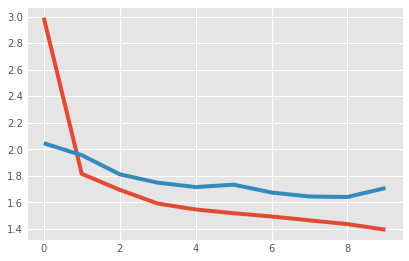

In [485]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')


In [486]:
test_preds = net(X_test_tensor)

test_preds = test_preds.detach().numpy()

In [487]:
test_preds

array([[  7.9767027],
       [  4.172577 ],
       [ -6.7563467],
       ...,
       [  4.2122855],
       [ -1.5891145],
       [-13.451335 ]], dtype=float32)

In [488]:
point_diff_test

6922    10
6923   -10
6924     2
6925   -12
6926    -2
        ..
8727    21
8728   -12
8729   -16
8730   -31
8731   -21
Name: point_diff, Length: 1579, dtype: int64

## Against the Spread

In [489]:
test_idx = X_test.index

betting_results = full_df.loc[test_idx, ['date', 'spread']]
betting_results['actual_point_diff'] = point_diff_test
betting_results['prediction'] = test_preds
betting_results['bet_home_team'] = (betting_results['prediction'] + betting_results['spread'] > 0).astype(int)

betting_results['home_covered'] = (betting_results['actual_point_diff'] + betting_results['spread'] > 0).astype(int)
betting_results['profit'] = betting_results.apply(lambda row: 100 if row['bet_home_team'] == row['home_covered'] else -110, axis=1)
betting_results['cume_profit'] = betting_results['profit'].cumsum()


betting_results['random_profit'] = np.random.choice([100, -110], betting_results.shape[0])
betting_results['random_cume_profit'] = betting_results['random_profit'].cumsum()
betting_results['prediction+spread'] = round(betting_results['prediction'] + betting_results['spread'], 2)
# betting_results.loc[betting_results['prediction+spread'].]

betting_results


,date,spread,actual_point_diff,prediction,bet_home_team,home_covered,profit,cume_profit,random_profit,random_cume_profit,prediction+spread
6922,2019-02-05,-8.5,10,7.976703,0,1,-110,-110,100,100,-0.52
6923,2019-02-05,-7.5,-10,4.172577,0,0,100,-10,100,200,-3.33
6924,2019-02-05,4.0,2,-6.756347,0,1,-110,-120,-110,90,-2.76
6925,2019-02-05,-2.5,-12,-4.134767,0,0,100,-20,-110,-20,-6.63
6926,2019-02-05,-3.0,-2,-1.735888,0,0,100,80,-110,-130,-4.74
...,...,...,...,...,...,...,...,...,...,...,...
8727,2021-02-04,-5.0,21,3.009887,0,1,-110,13860,-110,-18270,-1.99
8728,2021-02-04,-3.5,-12,-1.656942,0,0,100,13960,100,-18170,-5.16
8729,2021-02-04,-10.0,-16,4.212286,0,0,100,14060,-110,-18280,-5.79
8730,2021-02-04,-4.0,-31,-1.589115,0,0,100,14160,100,-18180,-5.59


LOL there's no waty

In [490]:
betting_results['profit'].value_counts()

 100    895
-110    684
Name: profit, dtype: int64

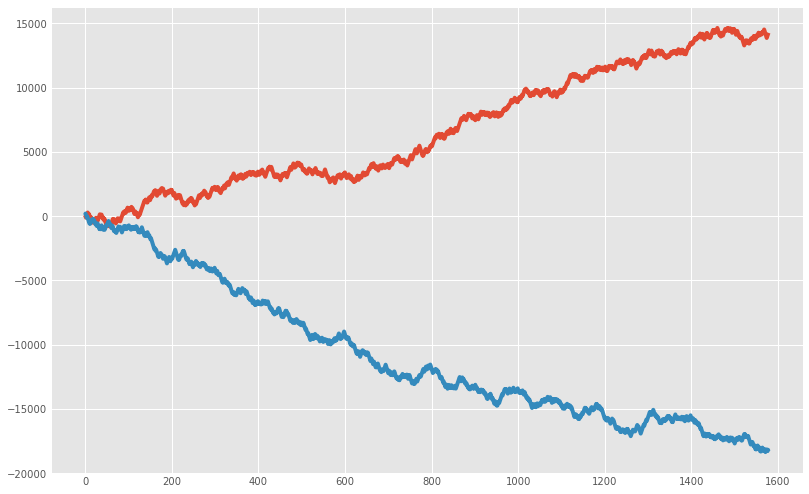

In [491]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(range(len(betting_results)), betting_results['cume_profit'])
ax.plot(range(len(betting_results)), betting_results['random_cume_profit'])

In [367]:
betting_results.head(20)

,date,spread,actual_point_diff,prediction,bet_home_team,home_covered,profit,cume_profit
6922,2019-02-05,-8.5,10,11.181911,1,1,100,100.0
6923,2019-02-05,-7.5,-10,-0.727213,0,0,100,200.0
6924,2019-02-05,4.0,2,-1.276149,1,1,100,300.0
6925,2019-02-05,-2.5,-12,2.338589,0,0,100,400.0
6926,2019-02-05,-3.0,-2,2.344773,0,0,100,500.0
6927,2019-02-05,2.5,42,-1.253889,1,1,100,600.0
6928,2019-02-05,3.0,-13,-0.685891,1,0,-110,490.0
6929,2019-02-05,10.0,-7,-1.356399,1,1,100,590.0
6930,2019-02-06,3.0,5,-1.246404,1,1,100,690.0
6931,2019-02-06,1.5,-5,-1.263035,1,0,-110,580.0


In [369]:
betting_results['profit'].value_counts()

 100    805
-110    774
Name: profit, dtype: int64

In [368]:
from sklearn.metrics import confusion_matrix

confusion_matrix(betting_results['home_covered'], betting_results['bet_home_team'])


array([[269, 557],
       [217, 536]], dtype=int64)